In [1]:
import os
import json
import numpy as np
import heapq
from matplotlib import colors
import matplotlib.pyplot as plt
import torch
import networkx as nx
from networkx.readwrite import json_graph

In [39]:
os_path = "figures/"

In [25]:
def llm_astar(G, start, goal, heuristic, llm_nodes):

    points = llm_nodes.copy()
    points.insert(0, start)
    points.append(goal)

    cum = 0
    path = []
    count = 0
    checking_edges = set()

    for i in range(len(points)-1):
        s = points[i]
        e = points[i+1]

        open_set = []
        heapq.heappush(open_set, (heuristic[s], 0, s))

        came_from = {}
        g_score = {node: float('inf') for node in G.nodes}
        g_score[s] = 0

        f_score = {node: float('inf') for node in G.nodes}
        f_score[s] = heuristic[s]

        visited = set()

        while open_set:
            _, current_g, current = heapq.heappop(open_set)

            if current == e:
                p = [current]
                while current in came_from:
                    current = came_from[current]
                    p.append(current)
                path += p[::-1]
                if path[-1] in llm_nodes:
                    path.pop()
                cum += current_g
                break

            visited.add(current)

            for neighbor in G.successors(current):
                count = count + 1
                if neighbor in visited:
                    continue

                tentative_g = g_score[current] + G[current][neighbor]['weight']
                checking_edges.add((current, neighbor))
                if tentative_g < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g
                    f_score[neighbor] = tentative_g + heuristic[neighbor]
                    heapq.heappush(open_set, (f_score[neighbor], tentative_g, neighbor))

    return path, cum, count, list(checking_edges)


In [47]:
def astar(G, start, goal, heuristic):
    count = 0
    checking_edges = set()

    open_set = []
    heapq.heappush(open_set, (heuristic[start], 0, start))

    came_from = {}
    g_score = {node: float('inf') for node in G.nodes}
    g_score[start] = 0

    f_score = {node: float('inf') for node in G.nodes}
    f_score[start] = heuristic[start]

    visited = set()

    while open_set:
        _, current_g, current = heapq.heappop(open_set)

        if current == goal:
            path = [current]
            while current in came_from:
                current = came_from[current]
                path.append(current)
            return path[::-1], current_g, count, list(checking_edges)

        visited.add(current)

        for neighbor in G.successors(current):
            count = count + 1
            if neighbor in visited:
                continue

            tentative_g = g_score[current] + G[current][neighbor]['weight']
            checking_edges.add((current, neighbor))
            if tentative_g < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g
                f_score[neighbor] = tentative_g + heuristic[neighbor]
                heapq.heappush(open_set, (f_score[neighbor], tentative_g, neighbor))

    return None, None, count, list(checking_edges)


def plot_bus_graph(G, path=None, start=None, goal=None,
                   checking_edges=None, weight_tag=True,
                   route_tag=False, node_size=50,
                   title="Bus Routes Graph"):
    """
    - path: A* 결과 (정류장ID list)
    - start, goal: 노드(정류장ID)
    - checking_edges: 탐색 중 확인한 엣지
    - weight_tag: True면 edge weight 표시
    - route_tag: True면 edge에 노선명(route_name) 표시
    - node_size: 노드 크기 
    """

    # (1) 노드 위치를 (x, y) 좌표로 지정
    pos = {}
    for n in G.nodes():
        x_coord = G.nodes[n].get('x', 0.0)
        y_coord = G.nodes[n].get('y', 0.0)
        pos[n] = (x_coord, y_coord)

    # (2) 그림 크기, 축 등
    plt.figure(figsize=(20, 16))

    # (3) 전체 엣지
    nx.draw_networkx_edges(
        G, pos,
        edge_color='gray',
        alpha=0.5,
        arrows=True,
        connectionstyle='arc3,rad=0.05'
    )

    # (4) path 강조
    if path:
        path_edges = list(zip(path, path[1:]))

        # 탐색 중 확인한 엣지 (주황색)
        if checking_edges:
            nx.draw_networkx_edges(
                G, pos,
                edgelist=checking_edges,
                edge_color='orange',
                alpha=0.4,
                width=3,
                arrows=True,
                connectionstyle='arc3,rad=0.05'
            )
        # 최종 경로 (빨간색)
        nx.draw_networkx_edges(
            G, pos,
            edgelist=path_edges,
            edge_color='red',
            width=5,
            arrows=True,
            connectionstyle='arc3,rad=0.05'
        )

    # (5) 노드 표시
    else:
        labels = {node: str(node) for node in G.nodes()}
        nx.draw_networkx_nodes(
            G, pos,
            node_size=node_size,
            node_color='lightblue'
        )

    # (6) 엣지 라벨
    if weight_tag:
        edge_labels = {
            (u, v): G[u][v].get('weight', '')
            for u, v in G.edges()
        }
        nx.draw_networkx_edge_labels(
            G, pos,
            edge_labels=edge_labels,
            font_color='green'
        )
    elif route_tag:
        edge_labels = {
            (u, v): G[u][v].get('route_name', '')
            for u, v in G.edges()
        }
        nx.draw_networkx_edge_labels(
            G, pos,
            edge_labels=edge_labels,
            font_color='blue'
        )


    if path and start and goal:
        title = f"{title}\nStart: {start}, Goal: {goal}"

    plt.title(title, fontsize=13)
    plt.axis('off')
    #plt.tight_layout()
    plt.savefig(os_path + title + '.png' , dpi=200)
    plt.show()

In [48]:
with open("graphs/sejong_bus.json", "r") as json_file:
    j = json.load(json_file)

G = json_graph.node_link_graph(j)
nodes = G.nodes
edges = G.edges
stations = list(G.nodes())
heuristic_table = {station: np.random.randint(0, 10) for station in stations}

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_graph(data, edges="links") to preserve current behavior, or
  nx.node_link_graph(data, edges="edges") for forward compatibility.
  warnings.warn(


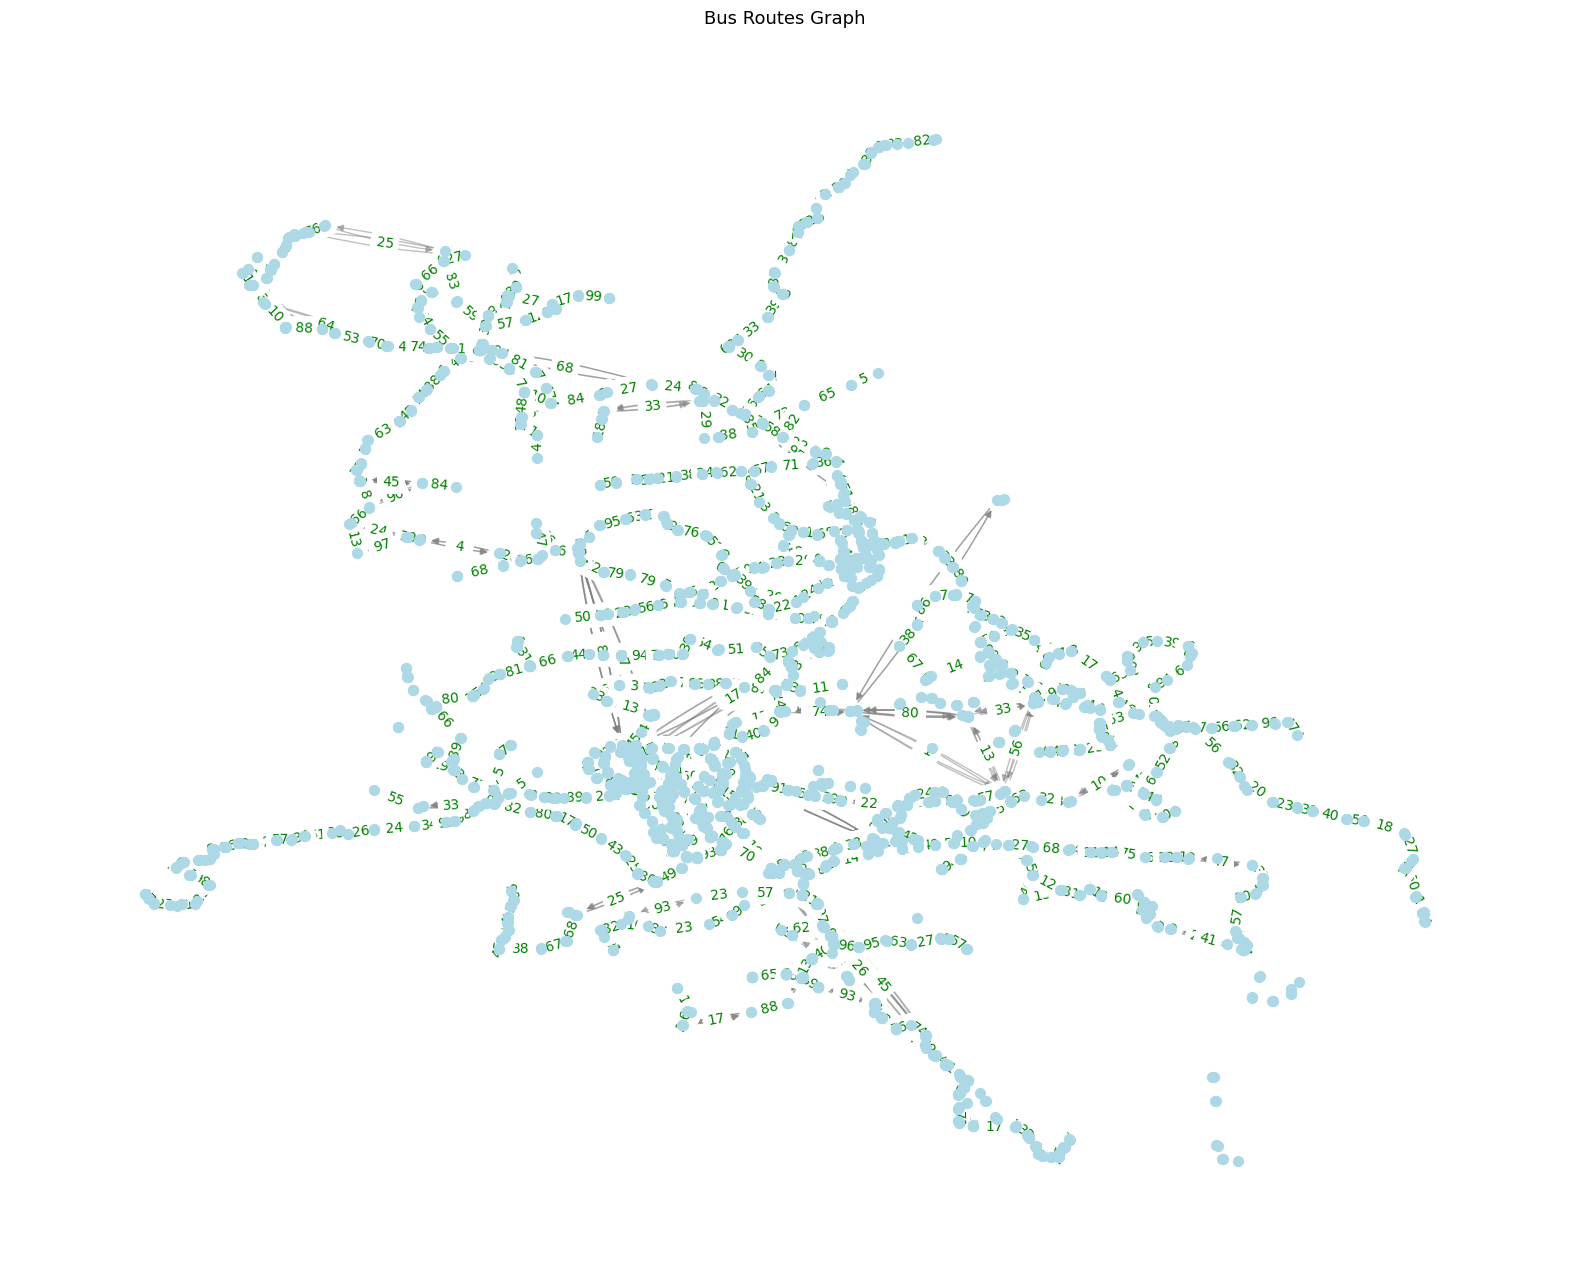

In [49]:
plot_bus_graph(G)

Count       : 2724
Cost        : 583
# of Checking edges: 1236
Path        : [6800031, 6802361, 6802359, 6801162, 6801842, 6805814, 6806337, 6806335, 6802389, 6802391, 6802393, 6800324, 6800316, 6800974, 6806239, 6800315, 6800109]


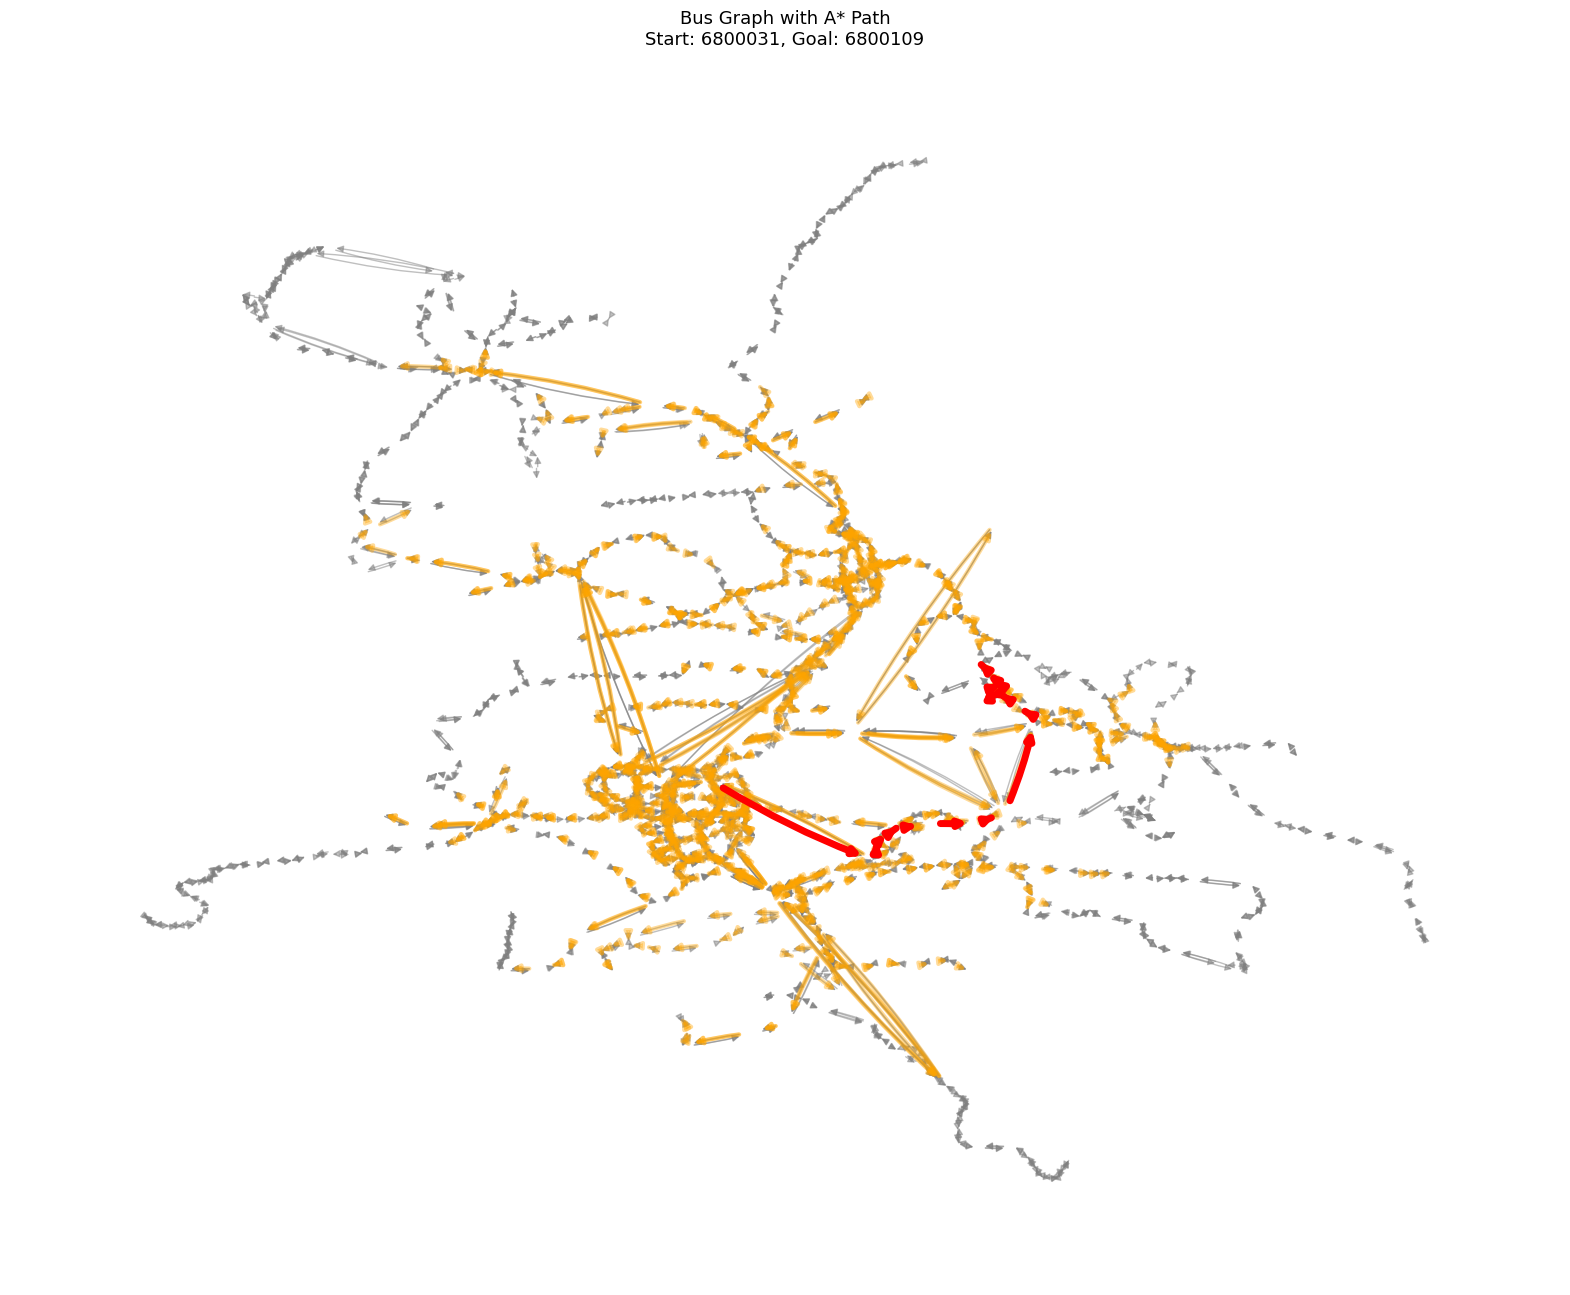

In [50]:
# A* 시연
start = stations[30]            
goal = stations[100]           
path, cost, count, checking_edges = astar(G, start, goal, heuristic_table)

print("Count       :", count)
print("Cost        :", cost)
print("# of Checking edges:", len(checking_edges))
print("Path        :", path)
plot_bus_graph(
    G,
    path=path,
    start=start,
    goal=goal,
    checking_edges=checking_edges,
    weight_tag=False,  
    route_tag=False,   
    title="Bus Graph with A* Path"
)

Count       : 2586
Cost        : 583
# of Checking edges: 1171
Path        : [6800031, 6802361, 6802359, 6801162, 6801842, 6805814, 6806337, 6806335, 6802389, 6802391, 6802393, 6800324, 6800316, 6800974, 6806239, 6800315, 6800109]


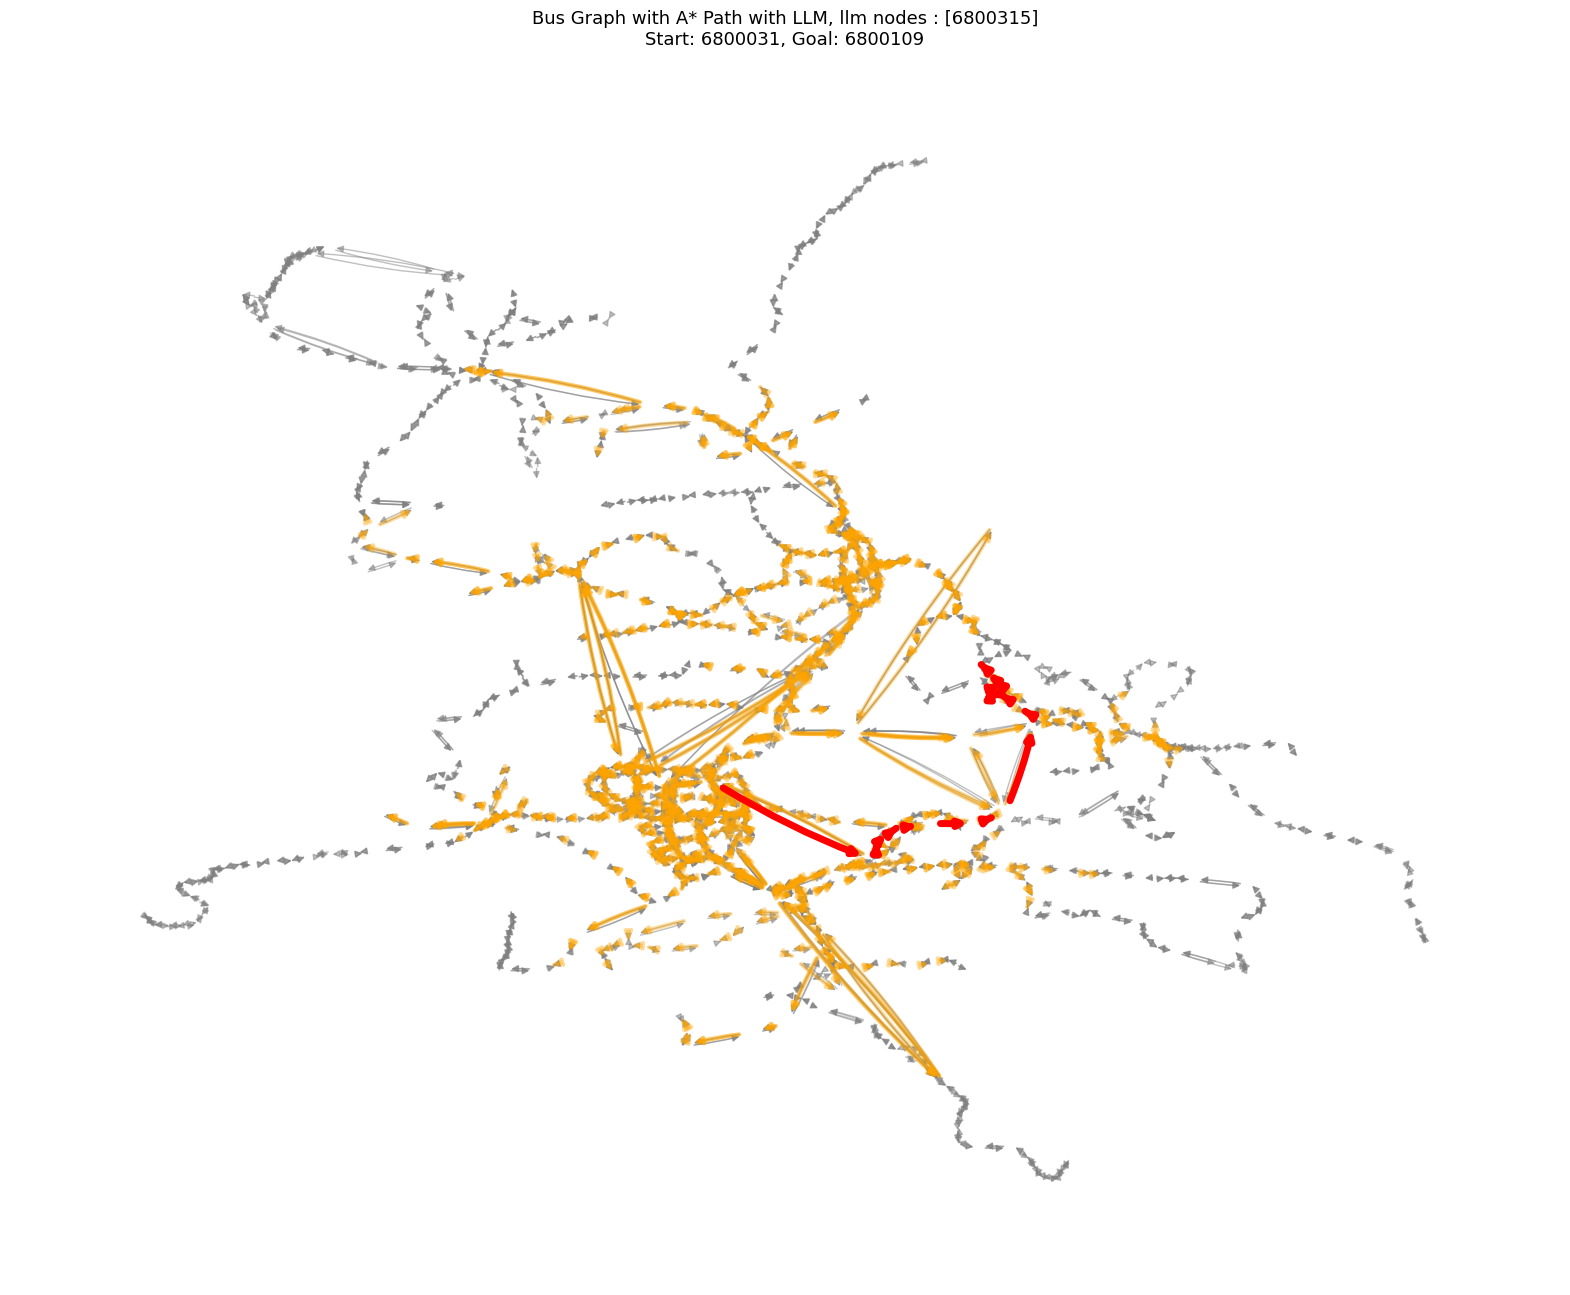

In [54]:
# LLM A* 시연
start = stations[30]            
goal = stations[100]  
llm_nodes = [6800315]
path, cost, count, checking_edges= llm_astar(G, start, goal, heuristic_table, llm_nodes)

print("Count       :", count)
print("Cost        :", cost)
print("# of Checking edges:", len(checking_edges))
print("Path        :", path)
plot_bus_graph(
    G,
    path=path,
    start=start,
    goal=goal,
    checking_edges=checking_edges,
    weight_tag=False,  
    route_tag=False,   
    title=f"Bus Graph with A* Path with LLM, llm nodes : {llm_nodes}"
)

Count       : 2487
Cost        : 583
# of Checking edges: 1116
Path        : [6800031, 6802361, 6802359, 6801162, 6801842, 6805814, 6806337, 6806335, 6802389, 6802391, 6802393, 6800324, 6800316, 6800974, 6806239, 6800315, 6800109]


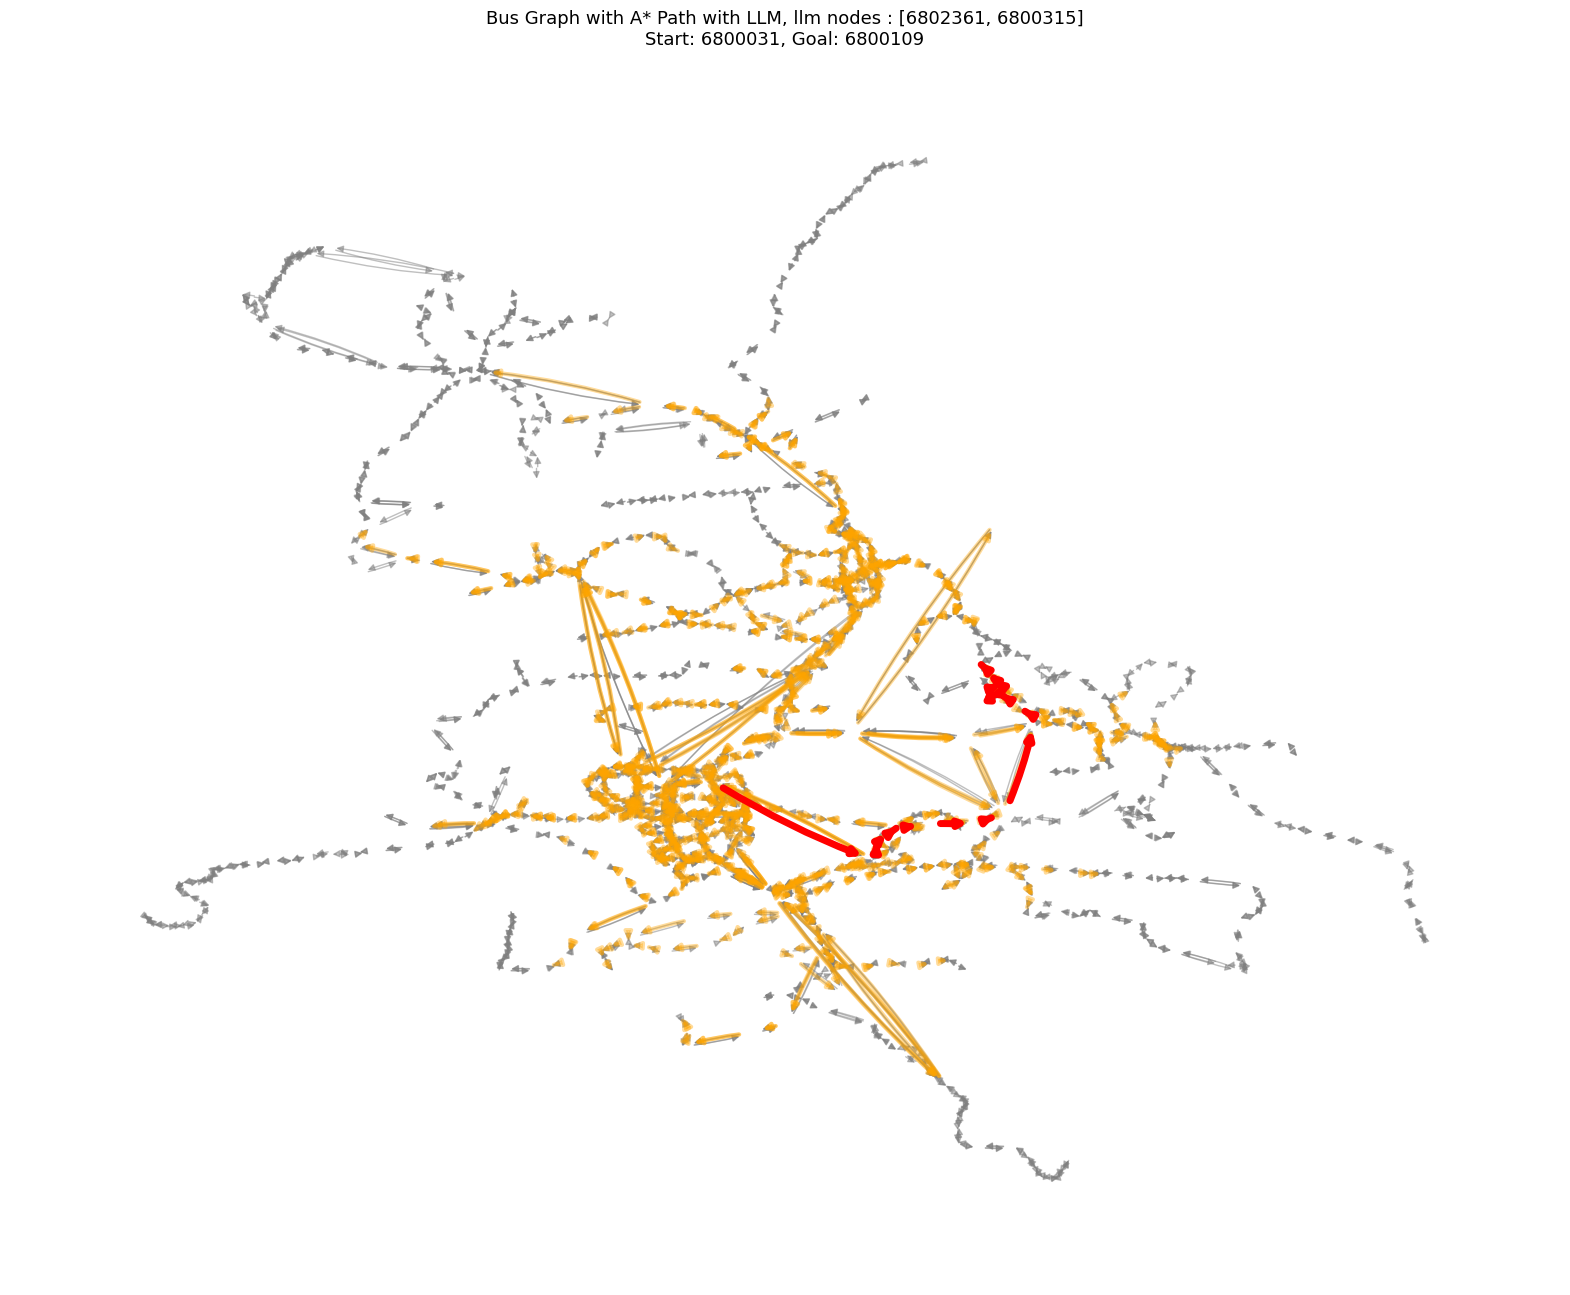

In [55]:
# LLM A* 시연
start = stations[30]            
goal = stations[100]  
llm_nodes = [6802361,6800315]
path, cost, count, checking_edges= llm_astar(G, start, goal, heuristic_table, llm_nodes)

print("Count       :", count)
print("Cost        :", cost)
print("# of Checking edges:", len(checking_edges))
print("Path        :", path)
plot_bus_graph(
    G,
    path=path,
    start=start,
    goal=goal,
    checking_edges=checking_edges,
    weight_tag=False,  
    route_tag=False,   
    title=f"Bus Graph with A* Path with LLM, llm nodes : {llm_nodes}"
)

Count       : 2305
Cost        : 709
# of Checking edges: 977
Path        : [6800031, 6802361, 6800016, 6801179, 6800031, 6802361, 6802359, 6801162, 6801842, 6805814, 6806337, 6806335, 6802389, 6802391, 6802393, 6800324, 6800316, 6800974, 6806239, 6800315, 6800109]


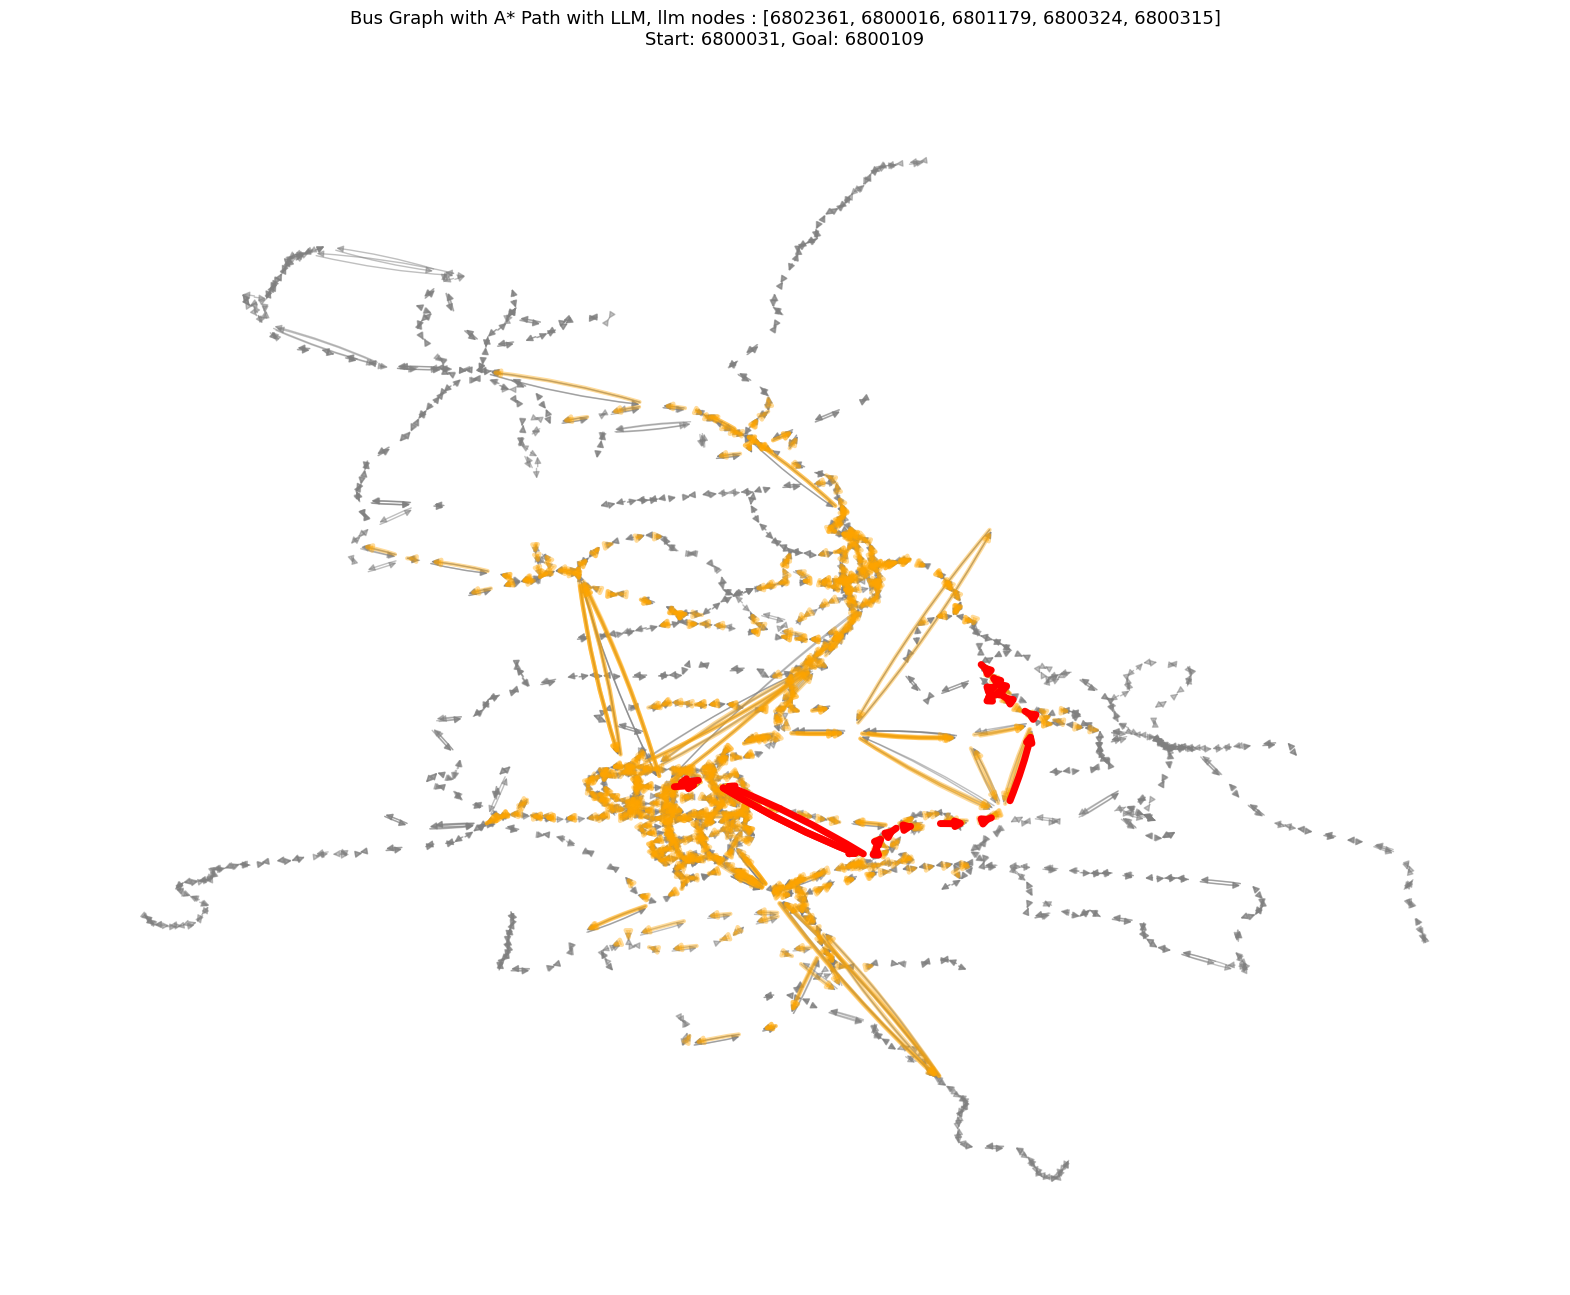

In [56]:
# LLM A* 시연
start = stations[30]            
goal = stations[100]  
llm_nodes = [6802361, 6800016, 6801179, 6800324, 6800315]
path, cost, count, checking_edges= llm_astar(G, start, goal, heuristic_table, llm_nodes)

print("Count       :", count)
print("Cost        :", cost)
print("# of Checking edges:", len(checking_edges))
print("Path        :", path)
plot_bus_graph(
    G,
    path=path,
    start=start,
    goal=goal,
    checking_edges=checking_edges,
    weight_tag=False,  
    route_tag=False,   
    title=f"Bus Graph with A* Path with LLM, llm nodes : {llm_nodes}"
)